# Run our Method on Silicon Simulations
Just to see if the methods work equally-well for Si

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_qbox_data
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from glob import glob
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import os

## Load in Data
Read in data from the `v = 1.0` simulation

In [21]:
data = []
for file in tqdm(glob('Si/v_1.0/Si*.out')):
    frame = load_qbox_data(file)
    frame['file'] = file
    data.append(frame)
data = pd.concat(data)
print('Read in %d training points'%len(data))


Read in 2106 training points


In [22]:
data.sort_values(['file_id', 'frame_id'], ascending=True, inplace=True)

In [23]:
data['timestep'] = list(range(len(data)))

In [24]:
data.set_index('timestep', inplace=True, drop=False)

Compute the displacement

In [25]:
data['displacement'] = (data['position'] - data['position'][0]).apply(np.linalg.norm)

## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

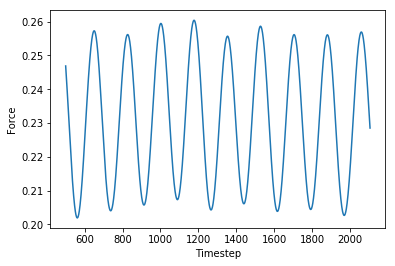

In [28]:
fig, ax = plt.subplots()

plot_max = 3000
ax.plot(data['timestep'].iloc[:plot_max], data['force'].iloc[:plot_max])

ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

After 750 seems good

In [27]:
data.query('timestep >= 500', inplace=True)

## Load in the Charge Density
Get the ground state charge density without the particle. Plot it to make sure it looks correct

In [9]:
charge, cell = get_charge_density_interpolator(os.path.join('Si',
                                                            'charge_density_ground_state_bulk_si',
                                                            'Si_4_val_elec_gs.cub'))

Plot the charge density along the [1,0,0] direction. Should be 4 bumps (one is split)

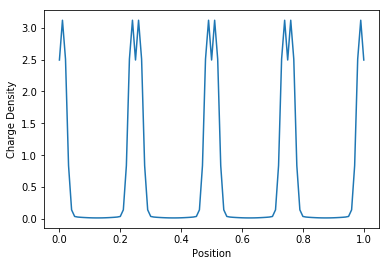

In [29]:
fig, ax = plt.subplots()

x = np.array(list(zip(np.linspace(0,1,101), [0,]*101, [0,]*101)))

ax.plot(x[:,0], charge(x))

ax.set_xlabel('Position')
ax.set_ylabel('Charge Density')

Plot the charge density along the [1,1,0] direction. Should be 8 bumps (one is split)

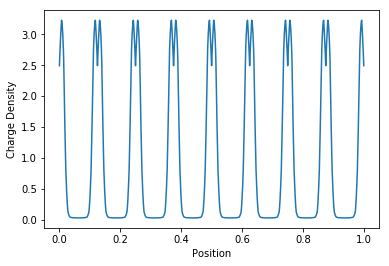

In [30]:
fig, ax = plt.subplots()

x = np.array(list(zip(np.linspace(0,1,1001), np.linspace(0,1,1001), [0,]*1001)))

ax.plot(x[:,0], charge(x))

ax.set_xlabel('Position')
ax.set_ylabel('Charge Density')

## Generate Features
Use the same features at the Al model

In [31]:
featurizers = [
    LocalChargeDensity(charge, np.linspace(1, -5, 7)),
    ProjectedAGNIFingerprints(etas=np.logspace(np.log10(0.8), np.log10(16), 8)),
    IonIonForce(acc=2)
]

In [32]:
%%time
for f in featurizers:
    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)

CPU times: user 1.15 s, sys: 1.04 s, total: 2.19 s
Wall time: 2min 17s


In [33]:
X_cols = sum([f.feature_labels() for f in featurizers], [])
y_col = 'force'

Plot the ion-ion repulsion. It should very periodic

In [34]:
X_cols

['density t=1.000000',
 'density t=0.000000',
 'density t=-1.000000',
 'density t=-2.000000',
 'density t=-3.000000',
 'density t=-4.000000',
 'density t=-5.000000',
 'AGNI eta=8.00e-01',
 'AGNI eta=1.23e+00',
 'AGNI eta=1.88e+00',
 'AGNI eta=2.89e+00',
 'AGNI eta=4.43e+00',
 'AGNI eta=6.80e+00',
 'AGNI eta=1.04e+01',
 'AGNI eta=1.60e+01',
 'ion-ion repulsion']

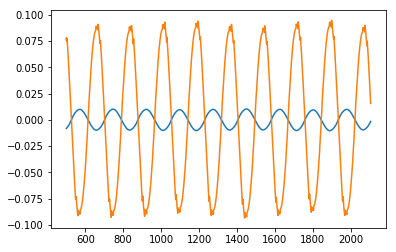

In [49]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['AGNI eta=1.60e+01'])
ax.plot(data['timestep'], data['ion-ion repulsion'])

## Fit the model
Use Bayesian Ridge Regression. Train on progressively larger slices, and see how the model does.

In [36]:
model = BayesianRidge(normalize=True)

In [37]:
def train_over_time(model, data, steps=None):
    """Train the model on increasingly-larger amounts of data
    
    :param model: model to be tested
    :param data: training/test data
    :param steps: increments to test at. Model is trained at all entries before this timestep
    :return: 
        - train_size: Number of training points
        - average_force: Average force (i.e., stopping power) as at each step
        - trajectory: Full trajectory
        - step: timestep
    """
    
    # Get the default steps
    if steps is None:
        steps = np.linspace(data['timestep'].min(), data['timestep'].max(), 31, dtype=np.int)[1:]
        
    # Test the models
    mean_forces = []
    trajs = []
    force_errors = []
    train_size = []
    for step in steps:
        # Train model on all timesteps before current
        train_data = data.query('timestep <= %d'%step)
        train_size.append(len(train_data))
        model.fit(train_data[X_cols], train_data[y_col])
        
        
        # Predict on all timesteps
        traj = model.predict(data[X_cols])
        
        # Store results
        mean_forces.append(traj.mean())
        trajs.append(traj)
        force_errors.append((traj - data[y_col]).mean())
    
    return train_size, mean_forces, trajs, steps

In [38]:
train_size, mean_forces, trajs, steps = train_over_time(model, data)

Plot the fitness with gradually more data

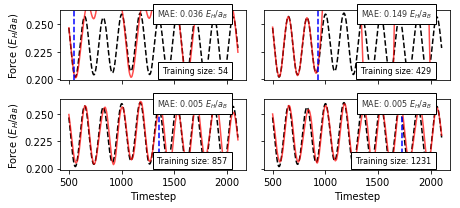

In [47]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

n_tests = len(train_size)
for f,ax in zip([0,int(0.25*30),int(0.5*30),int(0.75*30)],axs.flatten()):
    
    ax.plot(data['timestep'], data['force'], 'k--')
    ax.set_ylim(ax.get_ylim()) # Make sure the scales stay appropriate
    
    traj = trajs[f]
    ax.plot(data['timestep'], traj, 'r-', alpha=0.7)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(0.9, 0.9, 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=8, ha='right',
           bbox=dict(edgecolor='k', facecolor='w'), transform=ax.transAxes, alpha=0.8)
    
    ax.text(0.9, 0.1, 'Training size: %d'%train_size[f], ha='right',
            fontsize=8, transform=ax.transAxes,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.plot([steps[f],]*2, ax.get_ylim(), 'b--')

axs[1,0].set_xlabel('Timestep')
axs[1,1].set_xlabel('Timestep')
axs[0,0].set_ylabel('Force ($E_H/a_B$)')
axs[1,0].set_ylabel('Force ($E_H/a_B$)')

## Unscale force
#y_ticks = [-100, -20, 0, 20, 100]
#axs[0,0].set_yticks(scale_force(y_ticks))
#axs[0,0].set_yticklabels(['%.1f'%f for f in y_ticks])
#axs[1,0].set_yticks(scale_force(y_ticks))
#axs[1,0].set_yticklabels(['%.1f'%f for f in y_ticks])

fig.set_size_inches(6.5,3)
fig.tight_layout()
fig.savefig('ml_over_time.pdf')
fig.savefig('ml_over_time.png', dpi=320)